# Feature Engineering

Feature Analysis and transformations:
 - Skewness Detection
 - Log Transformation
 - Binning
 - Binned features analysis
 - Other transformations
 - Feature selection
 - Spliting and scaling data

In [1]:
# import libraries
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# import custom libraries
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from app.libs import data_utils, eda_tools
from app.config import SCHEMA

In [2]:
# Read data
file_path = parent_dir + '/data/processed/'
df = data_utils.read_data(file_path, 'features.csv')
features = list(SCHEMA['features'].keys())

df = df.drop(columns=[col for col in df.columns if col.startswith('Unnamed')])

{"time": "2024-08-08T15:09:14Z", "level": "INFO", "log": "Reading c:\\Users\\MULTIVISION\\projects\\tennis-predictor\\venv/data/processed/features.csv..."}
{"time": "2024-08-08T15:09:15Z", "level": "INFO", "log": "Shape of the dataset: (39364, 33)"}


In [3]:
df.columns

Index(['date', 'winner', 'loser', 'wrank', 'lrank', 'b365w', 'b365l',
       'winner_is_p1', 'match_id', 'rank_p1', 'rank_p2', 'rank_diff',
       'rank_ratio', 'odd_p1', 'odd_p2', 'odd_diff', 'odd_ratio',
       'surface_Clay', 'surface_Grass', 'surface_Hard', 'h2h',
       'consecutive_wins_p1', 'consecutive_losses_p1', 'consecutive_wins_p2',
       'consecutive_losses_p2', 'consecutive_results', 'rank_evol_p1',
       'rank_evol_p2', 'rank_combined', 'record_p1', 'record_p2'],
      dtype='object')

### Skewness Detection

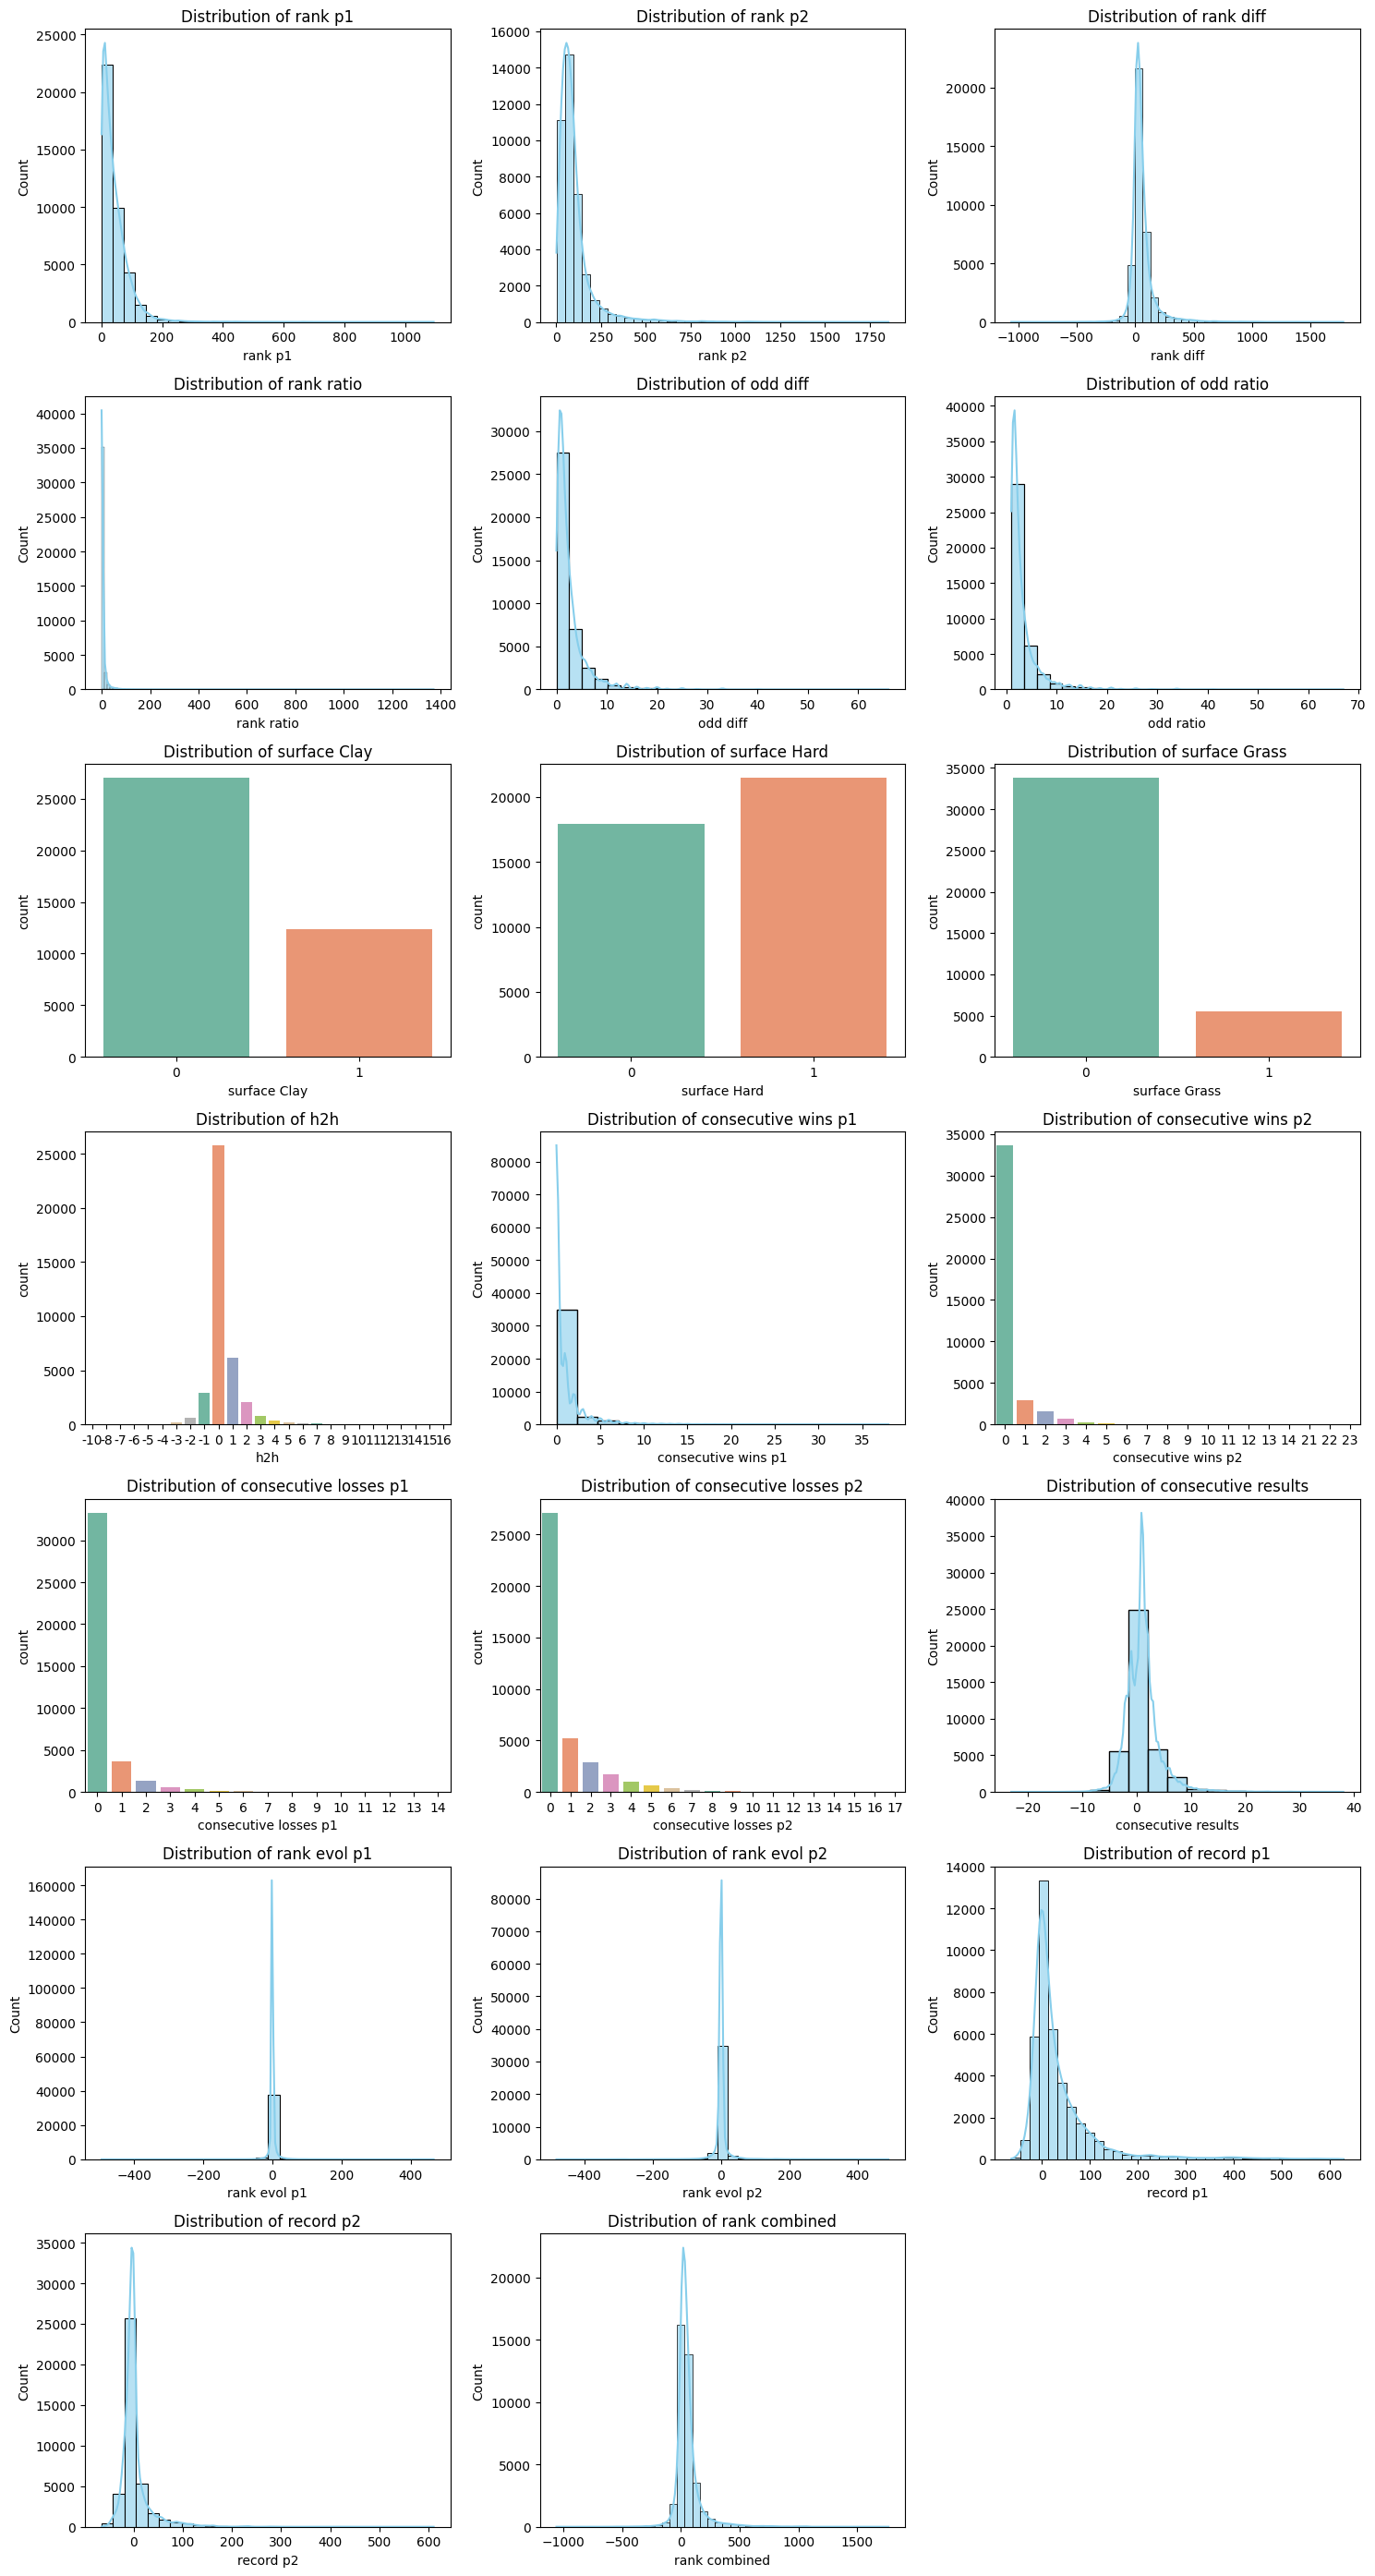

In [4]:
eda_tools.visualize_pd_series(df, features, skew_threshold=99, percentile_threshold=100)

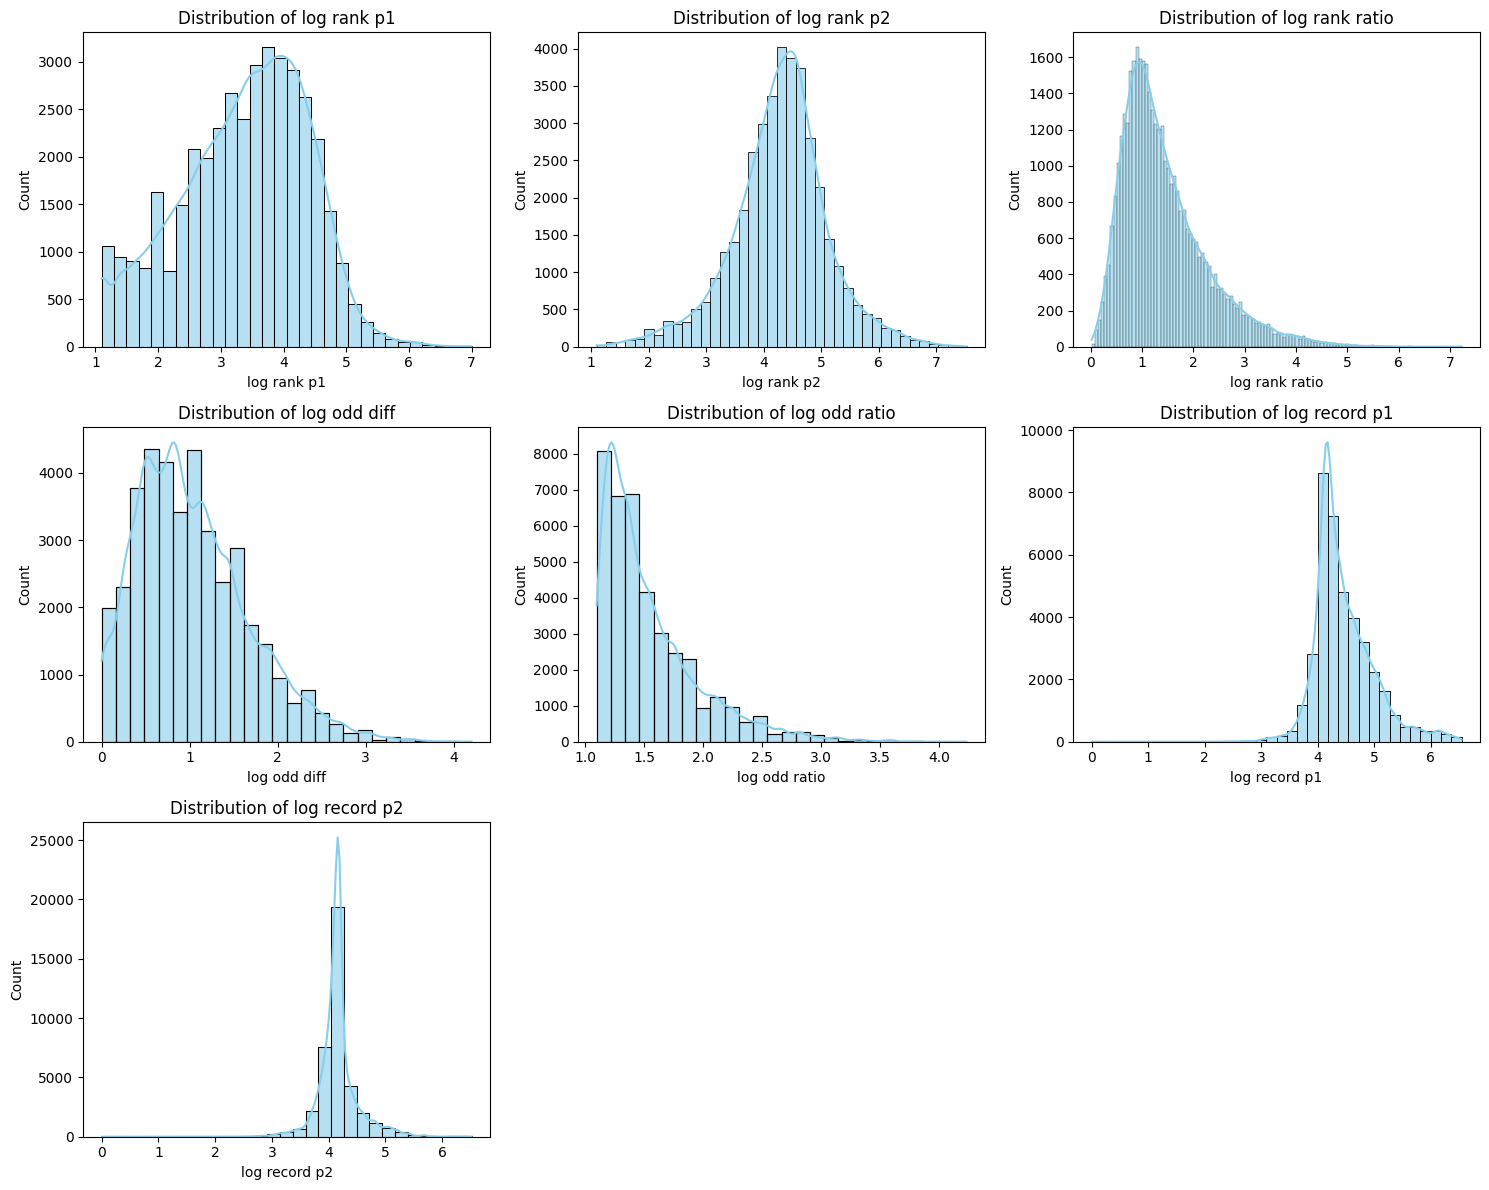

In [5]:
skewed_features = ['rank_p1', 'rank_p2', 'rank_ratio', 'odd_diff', 'odd_ratio', 'record_p1', 'record_p2']

# Apply logaritmic trasformation to skewed features
for col in skewed_features:
    if df[col].min() == 0:
        df[col] = df[col].apply(lambda x: x + 1)
    else:
        df[col] = df[col].apply(lambda x: x + 1 + abs(df[col].min()))
    df[f'log_{col}'] = df[col].apply(lambda x: np.log(x))

    # Updating features list
    i = features.index(col)
    features[i] = f'log_{col}'

df = df.drop(columns=skewed_features)

# Visualize log features
log_features = [feature for feature in features if feature.startswith('log')]
eda_tools.visualize_pd_series(df, log_features, skew_threshold=99, percentile_threshold=100)

#### Binning Features (discretize continuous numerical features into categorical bins) 
We will bin features that have consistent distributions but uneven frequencies among their values.

In [6]:
binning_features = {'rank_diff': 14,
                    'h2h': 2,
                    'rank_evol_p1': 2,
                    'rank_evol_p2': 2,
                    'rank_combined': 14}

# Iterate over each feature in binning_features
for col, bin in binning_features.items():
    # Calculate quantile boundaries
    quantiles = np.linspace(0, 100, bin+1)
    bin_boundaries = np.percentile(df[col], quantiles)

    # Apply binning transformation
    df[f'{col}_binned'] = pd.cut(df[col], bins=bin_boundaries, labels=False, include_lowest=True)

    binning_features[col] = (bin, (bin_boundaries))

    i = features.index(col) 
    features[i] = f'{col}_binned'

    # Print the quantile boundaries for the current feature
    print(f"Feature '{col}' Quantile Boundaries:")
    for i, boundary in enumerate(bin_boundaries):
        print(f"  Bin {i}: {boundary}")

    print()  # Print an empty line for separation

df = df.drop(columns=binning_features)

Feature 'rank_diff' Quantile Boundaries:
  Bin 0: -1059.0
  Bin 1: -24.0
  Bin 2: -4.0
  Bin 3: 6.0
  Bin 4: 13.0
  Bin 5: 20.0
  Bin 6: 28.0
  Bin 7: 35.0
  Bin 8: 44.0
  Bin 9: 54.0
  Bin 10: 66.0
  Bin 11: 83.0
  Bin 12: 109.0
  Bin 13: 173.35714285714494
  Bin 14: 1778.0

Feature 'h2h' Quantile Boundaries:
  Bin 0: -10.0
  Bin 1: 0.0
  Bin 2: 16.0

Feature 'rank_evol_p1' Quantile Boundaries:
  Bin 0: -494.0
  Bin 1: 0.0
  Bin 2: 467.0

Feature 'rank_evol_p2' Quantile Boundaries:
  Bin 0: -482.0
  Bin 1: 0.0
  Bin 2: 490.0

Feature 'rank_combined' Quantile Boundaries:
  Bin 0: -1059.0
  Bin 1: -28.0
  Bin 2: -5.0
  Bin 3: 5.0
  Bin 4: 13.0
  Bin 5: 20.0
  Bin 6: 27.0
  Bin 7: 35.0
  Bin 8: 44.0
  Bin 9: 54.0
  Bin 10: 66.0
  Bin 11: 83.0
  Bin 12: 110.0
  Bin 13: 175.0
  Bin 14: 1767.0



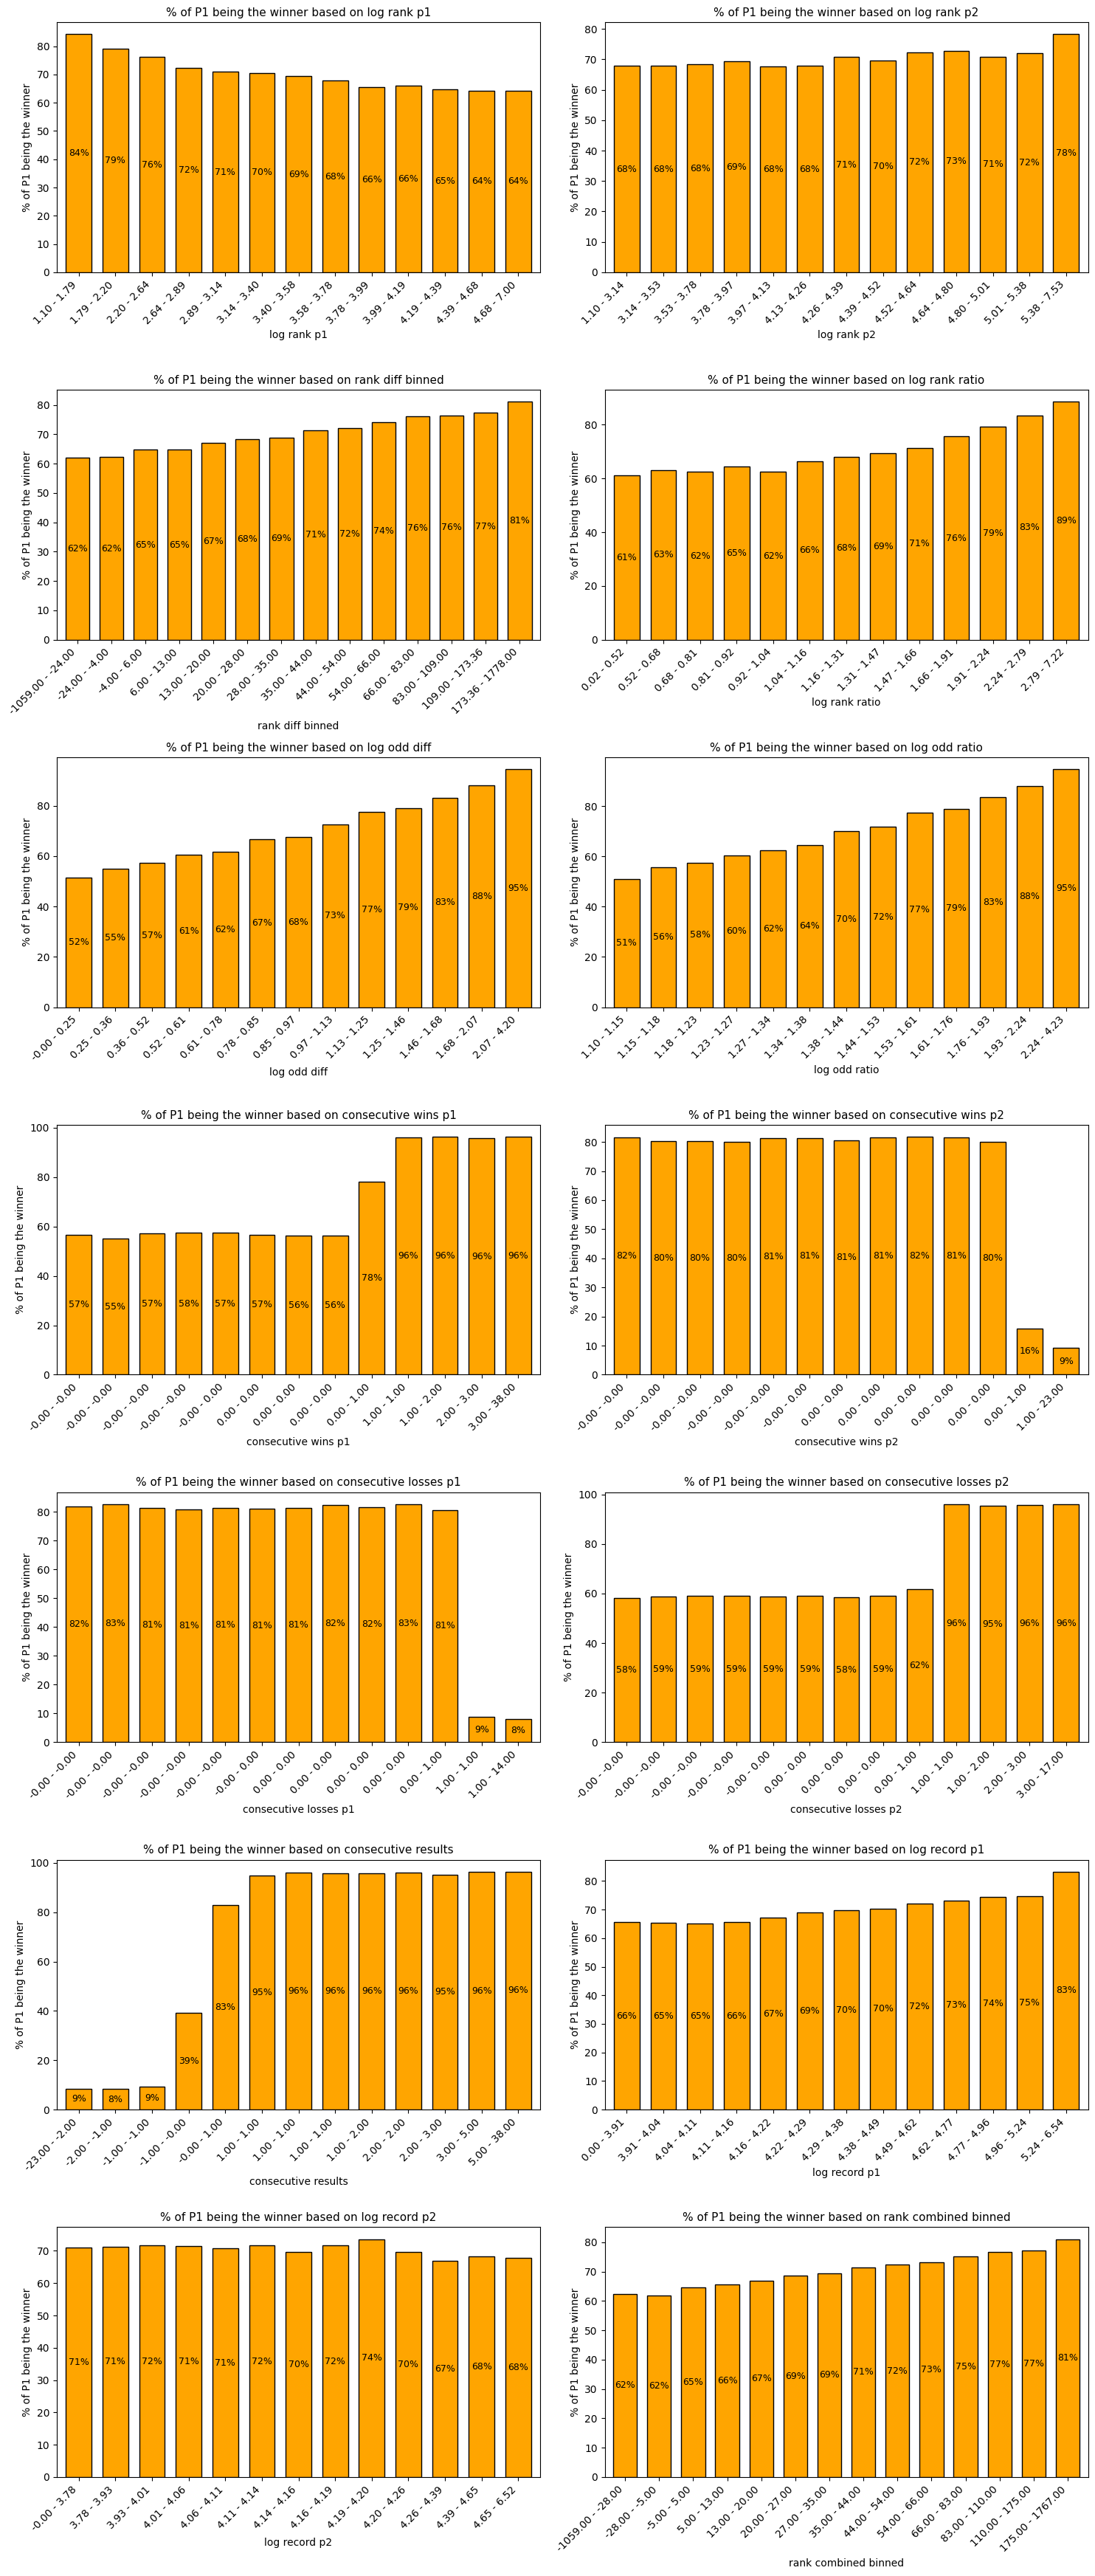

In [7]:
def plot_percentage_of_winner_is_p1(ax, feature):

    global df, binning_features
    
    # Create binned column using pd.cut and store bin edges
    if binning_features.get(feature.replace('_binned','')) is None:

        # Calculate quantile boundaries
        quantiles = np.linspace(0, 100, 14)
        noise = np.random.normal(0, 1e-6, df.shape[0])
        bin_boundaries = np.percentile(df[feature] + noise, quantiles)

        # Apply binning transformation
        df[f'{feature}_binned'] = pd.cut(df[feature] + noise, bins=bin_boundaries, labels=False, include_lowest=True)

        # Group by the bins and calculate the percentage of winner_is_p1
        grouped = df.groupby(f'{feature}_binned')['winner_is_p1'].mean() * 100

    else:
        bin_boundaries = binning_features[feature.replace('_binned','')][1]
        # Group by the bins and calculate the percentage of winner_is_p1
        grouped = df.groupby(feature)['winner_is_p1'].mean() * 100
    
    # Plot the bar chart
    grouped.plot(kind='bar', ax=ax, color='orange', edgecolor='black', width=0.7)
    ax.set_xlabel(feature.replace('_', ' '))
    ax.set_ylabel('% of P1 being the winner')
    ax.set_title(f'% of P1 being the winner based on {feature.replace('_', ' ')}', fontsize=11)

    # Annotating each bar with the percentage value
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height() / 2), 
                    ha='center', va='center', 
                    xytext=(0, 0), 
                    textcoords='offset points',
                    color='black', fontsize=9) 
        
    # Set x-tick labels to bin ranges
    bin_labels = [f'{bin_boundaries[i]:.2f} - {bin_boundaries[i+1]:.2f}' for i in range(len(bin_boundaries)-1)]
    ax.set_xticklabels(bin_labels, rotation=45, ha='right')

# Apply to non binary features 
filtered_features = [col for col in features if len(df[col].drop_duplicates()) > 2]

# Create subplots
n_features = len(filtered_features)
n_cols = 2
n_rows = (n_features + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(filtered_features):
    plot_percentage_of_winner_is_p1(axes[i], col)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Relationships founded between the percentage of p1 being the winner and each feature

Linear association:
 - rank_diff_binned
 - log_odd_ratio
 - rank_combined_binned

Reciprocal Relationship - Action: Apply 1 / x :
 - log_rank_p1

Sigmoidal (S-shaped) relationship - Action: Convert it into a binary feature:
 - consecutive_wins_p1
 - consecutive_losses_p2
 - consecutive_results

Inverse Sigmoidal (S-shaped) relationship - Action: Apply 1 / x and convert it into a binned feature:
 - consecutive_wins_p2
 - consecutive_losses_p1

Unclear Association (or there's a feature with clear association that represents the same information) - Action: Drop feature:
 - log_rank_p2
 - log_rank_ratio
 - log_odd_diff
 - log_record_p1
 - log_record_p2

In [8]:
# Invert features that have a negative impact 
inverse_features = ['log_rank_p1']

for col in inverse_features:
    df[f'inverted_{col}'] = 1 / df[col]
    i = features.index(col) 
    features[i] = f'inverted_{col}'

df = df.drop(columns=inverse_features)

# Convert into a binned feature based on the previous vizualisation
df['consecutive_wins_p1'] = df['consecutive_wins_p1'].apply(lambda x: 0 if x < 0 else (0.5 if 0 <= x <= 1 else 1))
df['consecutive_losses_p2'] = df['consecutive_losses_p2'].apply(lambda x: 0 if x < 0.9 else (0.5 if 0.9 <= x <= 1.1 else 1))
df['consecutive_results'] = df['consecutive_results'].apply(lambda x: 0 if x < 1 else 1)
df['consecutive_wins_p2'] = df['consecutive_wins_p2'].apply(lambda x: 0 if x > 1 else 1)
df['consecutive_losses_p1'] = df['consecutive_losses_p1'].apply(lambda x: 0 if x >= 1 else 1)

unclear_association_features =  ['log_rank_p2', 'log_rank_ratio', 'log_odd_diff', 'log_record_p1', 'log_record_p2']
df = df.drop(columns=unclear_association_features)
features = list(filter(lambda x: x not in unclear_association_features, features))

In [9]:
features

['inverted_log_rank_p1',
 'rank_diff_binned',
 'log_odd_ratio',
 'surface_Clay',
 'surface_Hard',
 'surface_Grass',
 'h2h_binned',
 'consecutive_wins_p1',
 'consecutive_wins_p2',
 'consecutive_losses_p1',
 'consecutive_losses_p2',
 'consecutive_results',
 'rank_evol_p1_binned',
 'rank_evol_p2_binned',
 'rank_combined_binned']

In [10]:
# Join 'odd_p1' and 'odd_p2' to X data to later use it in the custom loss function 
features.extend(['odd_p1', 'odd_p2'])
X = df[features]
y = df['winner_is_p1']

### Split and scale data

{"time": "2024-08-08T15:09:55Z", "level": "INFO", "log": "Splitting data randomly into a training (80.0%), a validation (10.0%) and a testing (10.0%) datasets."}


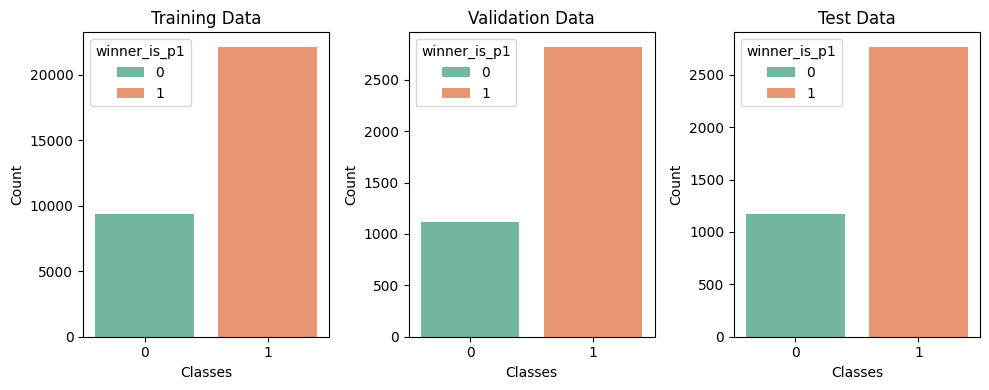

In [11]:
# Split into trainning, validation and testing datasets
X_train, X_val, X_test, y_train, y_val, y_test = data_utils.split_data(X, y, train_size=0.8, test_size=0.1)

# Check if distributions are homogeneous
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

datasets = [(y_train, 'Training Data'), (y_val, 'Validation Data'), (y_test, 'Test Data')]

for i, (y, title) in enumerate(datasets):
    sns.countplot(x=y, palette='Set2', hue=y, ax=axs[i])
    axs[i].set_title(title)
    axs[i].set_xlabel('Classes')
    axs[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [12]:
# Scale data between 0 and 1
X_train_scaled, X_val_scaled, X_test_scaled = data_utils.scaler_data(X_train, X_val, X_test)

In [13]:
# Save datasets
datasets = [(y_train, 'y_train'), (y_val, 'y_val'), (y_test, 'y_test'),
            (X_train, 'X_train'), (X_val, 'X_val'), (X_test, 'X_test')]

for df, name in datasets:
    file_path = os.path.join(parent_dir, 'data', 'processed', f'{name}.csv')
    df.to_csv(file_path)